In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset

Leggo i 4 csv forniti definendo i tipi per le varie colonne in modo da utilizzare meno spazio possibile in memoria

### Transactions csv

In [3]:
Transactions = pd.read_csv('DataSets/2013/transactions.csv',
                          names=['timestamp', 'blockId',
                                 'txId', 'isCoinbase', 'fee'],
                          dtype={'timestamp': 'int64', 'blockId': 'uint32',
                                 'txId': 'uint32', 'isCoinbase': 'bool', 'fee': 'uint64'})
Transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532115 entries, 0 to 10532114
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   timestamp   int64 
 1   blockId     uint32
 2   txId        uint32
 3   isCoinbase  bool  
 4   fee         uint64
dtypes: bool(1), int64(1), uint32(2), uint64(1)
memory usage: 251.1 MB


In [4]:
Transactions['timestamp'] = pd.to_datetime(Transactions['timestamp'],unit='s')

In [5]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532115 entries, 0 to 10532114
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   blockId     uint32        
 2   txId        uint32        
 3   isCoinbase  bool          
 4   fee         uint64        
dtypes: bool(1), datetime64[ns](1), uint32(2), uint64(1)
memory usage: 251.1 MB


### Inputs csv

In [6]:
Inputs = pd.read_csv('DataSets/2013/inputs.csv',
                     names=['txId', 'prevTxId', 'prevTxpos'],
                     dtype={'prevTxpos': 'uint16', 'prevTxId': 'uint32',
                                 'txId': 'uint32'}
                     )
Inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378770 entries, 0 to 21378769
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   txId       uint32
 1   prevTxId   uint32
 2   prevTxpos  uint16
dtypes: uint16(1), uint32(2)
memory usage: 203.9 MB


In [7]:
Inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378770 entries, 0 to 21378769
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   txId       uint32
 1   prevTxId   uint32
 2   prevTxpos  uint16
dtypes: uint16(1), uint32(2)
memory usage: 203.9 MB


### Outputs csv

In [8]:
Outputs = pd.read_csv('DataSets/2013/outputs.csv',
                      names=['txId', 'position', 'addressId',
                             'amount', 'scripttype'],
                      dtype={'txId': 'uint32',
                             'position': 'uint16',
                             'addressId': 'uint32',
                             'amount': 'uint64',
                             'scripttype ': 'int'})
Outputs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24573071 entries, 0 to 24573070
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   txId        uint32
 1   position    uint16
 2   addressId   uint32
 3   amount      uint64
 4   scripttype  int64 
dtypes: int64(1), uint16(1), uint32(2), uint64(1)
memory usage: 609.3 MB


In [9]:
Outputs['scripttype'] = Outputs['scripttype'].astype('category')

In [10]:
Outputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24573071 entries, 0 to 24573070
Data columns (total 5 columns):
 #   Column      Dtype   
---  ------      -----   
 0   txId        uint32  
 1   position    uint16  
 2   addressId   uint32  
 3   amount      uint64  
 4   scripttype  category
dtypes: category(1), uint16(1), uint32(2), uint64(1)
memory usage: 445.3 MB


### Mapping csv

In [11]:
Mapping = pd.read_csv('DataSets/2013/mapAddr2Ids8708820.csv',
                      names=['hash', 'addressId'])
Mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708821 entries, 0 to 8708820
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   hash       object
 1   addressId  int64 
dtypes: int64(1), object(1)
memory usage: 132.9+ MB


In [12]:
Mapping['addressId'] = pd.to_numeric(Mapping['addressId'],downcast='unsigned')

In [13]:
Mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708821 entries, 0 to 8708820
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   hash       object
 1   addressId  uint32
dtypes: object(1), uint32(1)
memory usage: 99.7+ MB


## Controlli di validità delle transazioni

- Input/output che fanno riferimento ad un tx_id non contenuto in
nessun blocco
- Input che fanno riferimento ad un output_id non esistente


Metto in left join il dataframe degli Input/Output con quello delle transazioni. Con il parametro `indicator` valorizzato a `True` posso contare le righe presenti in una sola delle due sorgenti o in entrambe

In [14]:
x = pd.merge(left=Inputs.set_index(['txId']), right=Transactions.set_index(['txId']), how='left', indicator=True,left_index=True,right_index=True)
x['_merge'].value_counts()


_merge
both          21378770
left_only            0
right_only           0
Name: count, dtype: int64

In [15]:
x = pd.merge(left=Outputs.set_index(['txId']), right=Transactions.set_index(['txId']), how='left', indicator=True,left_index=True,right_index=True)
x['_merge'].value_counts()

_merge
both          24573071
left_only            0
right_only           0
Name: count, dtype: int64

Tramite la funzione isin negata posso vedere quali input non provegono da nessun output appartenente ad una transazione precedente.
La `Series[bool]` risultante ha il solo valore `False`, significante l'assenza di input anomali

In [16]:
temp = ~Inputs['prevTxId'].isin(Outputs['txId'])
temp.describe()

count     21378770
unique           1
top          False
freq      21378770
Name: prevTxId, dtype: object

In [17]:
del temp
del x

## Analisi Generali

### Distribuzione numero transazioni per blocco

Ogni blocco può avere più transazioni al suo interno, per conoscere il numero di transazioni per ogni blocco effettuo un raggruppamento per il campo `blockId` e conto quanti `txId` ho per ogni blocco tramite la funzione di aggregazione `count`

Per rendere più leggibile il grafico ho raggruppato la coda destra includendo tutti i blocchi con più di 350 transazioni

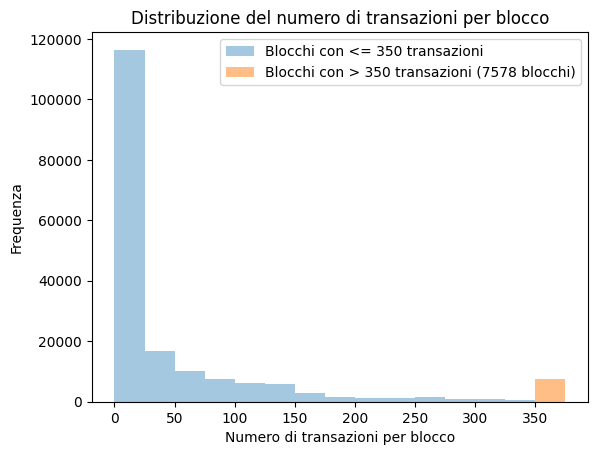

In [18]:
# raggruppa le transazioni per blockId e calcola il numero di transazioni per ogni blocco
tx_per_block = Transactions.groupby('blockId')['txId'].count().reset_index()
tx_per_block.rename(columns={'txId': 'num_tx'}, inplace=True)

# impostiamo la soglia e il valore da assegnare ai blocchi sopra la soglia
threshold = 350
clip_value = threshold + 1

# impostiamo i valori sopra la soglia al valore di clip
tx_per_block['num_tx'] = np.clip(tx_per_block['num_tx'], a_min=None, a_max=clip_value, out=None)

# calcoliamo l'istogramma dei valori entro il threshold
bin_width = 25
bins = np.arange(0, clip_value + bin_width, bin_width)
plt.hist(tx_per_block[tx_per_block['num_tx'] <= threshold]['num_tx'], bins=bins.tolist(), alpha=0.4, label='Blocchi con <= {} transazioni'.format(threshold))

# plottiamo un unico bin per i blocchi sopra la soglia
num_over_threshold = len(tx_per_block[tx_per_block['num_tx'] > threshold])
plt.hist(tx_per_block[tx_per_block['num_tx'] > threshold]['num_tx'], bins=bins.tolist(), alpha=0.5, label='Blocchi con > {} transazioni ({} blocchi)'.format(threshold, num_over_threshold))

plt.xlabel("Numero di transazioni per blocco")
plt.ylabel("Frequenza")
plt.title("Distribuzione del numero di transazioni per blocco")
plt.legend()
plt.show()

### Numero Transazioni medie su 2 mesi

Il dataframe Transactions viene raggruppato per il timestamp, calcolando il numero unico di transazioni ('txId') per ogni timestamp. Questi dati vengono poi utilizzati per creare il grafico delle transazioni totali nel tempo.

Successivamente, calcoliamo il primo timestamp nel nostro set di dati e troviamo il numero di giorni fino al successivo intervallo di 2 mesi. Questo viene utilizzato per correggere l'effetto di traslazione quando calcoliamo la media del numero di transazioni per blocco su un periodo di 2 mesi.

Creiamo poi un secondo asse y (ax2) che condivide lo stesso asse x con ax1. Questo ci permette di tracciare i dati della media del numero di transazioni per blocco sul secondo asse y. Nota che spostiamo l'indice di y indietro di mezzo intervallo per allineare i punti di dati al centro del loro intervallo.

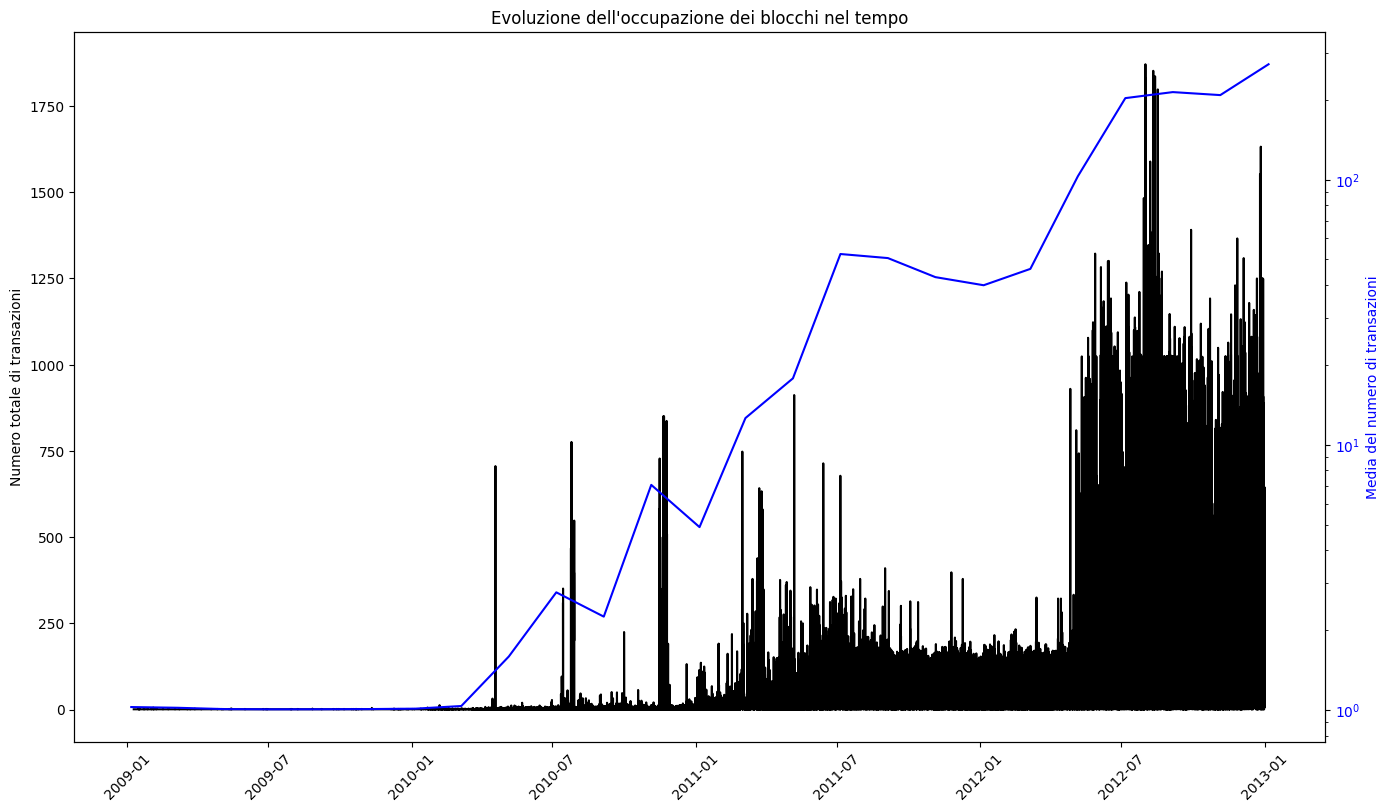

In [19]:

fig, ax1 = plt.subplots(figsize=(14, 8), dpi=100)
x = Transactions.groupby(['timestamp'], as_index=False)['txId'].nunique()

first_timestamp = x['timestamp'].min()
days_to_next_2M = (first_timestamp.to_period('2M') + 1).to_timestamp() - first_timestamp

y = x.resample(rule='2M',on='timestamp',origin='start')['txId'].mean()

# Mostra le etichette dell'asse x con una rotazione di 45 gradi
plt.xticks(rotation=45)

ax1.plot(x['timestamp'], x['txId'], label='Metodo 0', color='black')
ax1.set_ylabel('Numero totale di transazioni', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # istanzia un secondo asse che condivide lo stesso asse x
ax2.plot(y.index - pd.to_timedelta(days_to_next_2M.days, unit='d')/2, y.values, label='Metodo 1', color='blue')
ax2.set_ylabel('Media del numero di transazioni', color='blue')  # abbiamo già gestito l'asse x con ax1
ax2.tick_params(axis='y', labelcolor='blue')
plt.yscale('log')
fig.tight_layout()  # altrimenti l'asse destra potrebbe essere leggermente tagliata
plt.title("Evoluzione dell'occupazione dei blocchi nel tempo")
plt.show()


### UTXO totale

Per identificare gli output non spesi cerco gli ID delle transazioni in "Outputs" che non si trovano negli ID delle transazioni precedenti in "Inputs".

Successivamente ne calcolo la somma.

In [20]:
unspent_outputs = Outputs[~Outputs['txId'].isin(Inputs['prevTxId'])]
utxo_amount = unspent_outputs['amount'].sum()
print("Ammontare totale degli UTXO al momento dell'ultima transazione: {:,}".format(utxo_amount).replace(",", "."))

Ammontare totale degli UTXO al momento dell'ultima transazione: 218.593.937.985.378


Osservando il grafico del totale degli UXTO sul tempo noto un aumento sostanziale nelle ultime settimane, dovuto probabilmente al fatto che i dati sono troncati e quindi parte di questi UXTO sono stati spesi nelle transazioni successive al Gennaio 2013. Mentre l'aumento generale è in linea con l' aumento del volume delle transazioni.

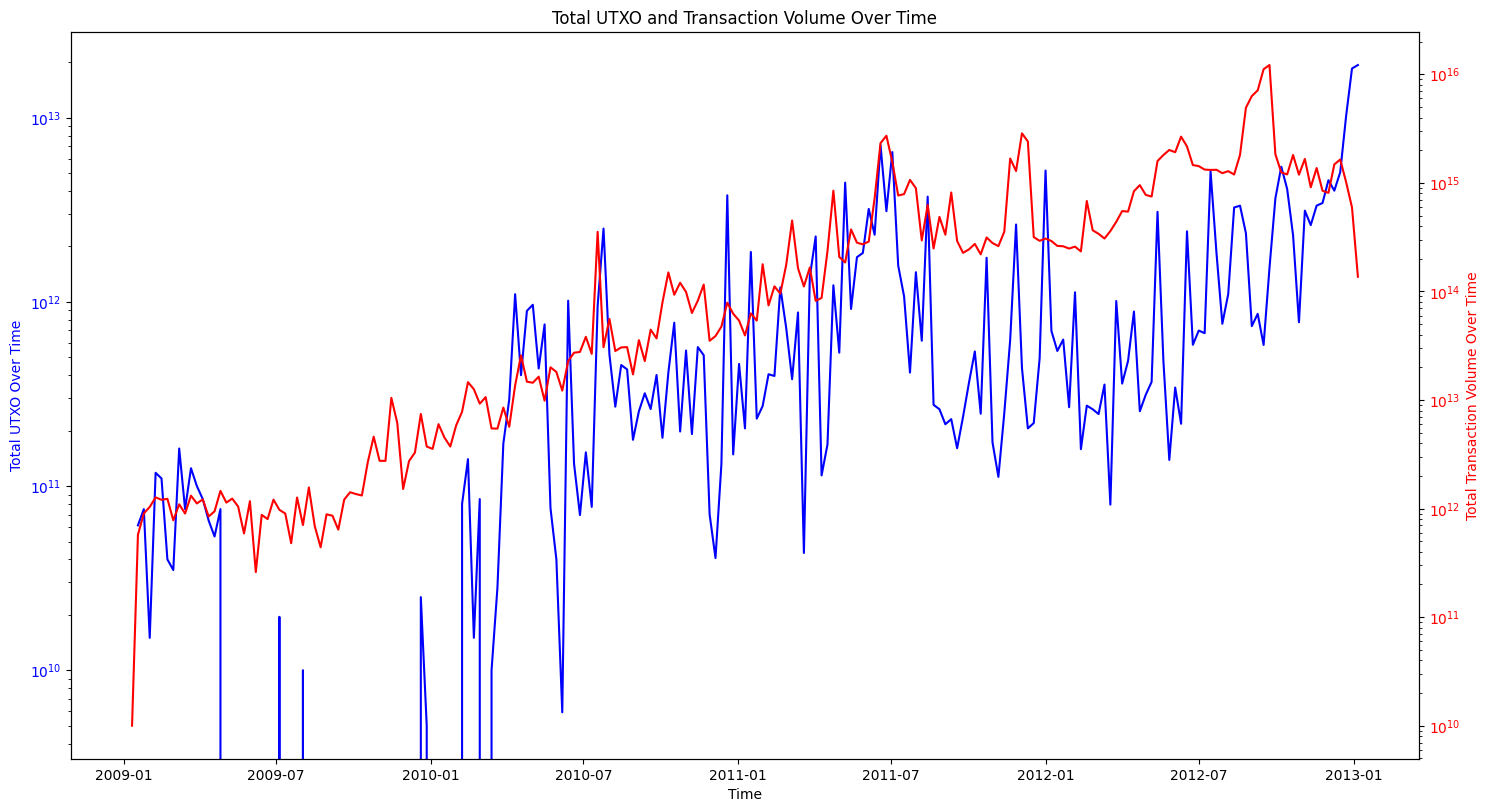

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 8))

# Calcolo e plot del Total UTXO Over Time
merged_data = pd.merge(unspent_outputs, Transactions[['txId', 'timestamp']], on='txId', how='left')
merged_data.set_index('timestamp', inplace=True)
utxo_over_time = merged_data.resample('W')['amount'].sum()

ax1.plot(utxo_over_time.index, utxo_over_time.values, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total UTXO Over Time', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')

ax2 = ax1.twinx()  # Crea un secondo asse y che condivide lo stesso asse x

# Calcolo e plot del Total Transaction Volume Over Time
merged_data = pd.merge(Outputs[['txId','amount']], Transactions[['txId', 'timestamp']], on='txId', how='left')
merged_data.set_index('timestamp', inplace=True)
tx_volume_over_time = merged_data.resample('W')['amount'].sum()

ax2.plot(tx_volume_over_time.index, tx_volume_over_time.values, color='red')
ax2.set_ylabel('Total Transaction Volume Over Time', color='red')  
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_yscale('log')

fig.tight_layout()  # per assicurarsi che la seconda y label sia visibile completamente
plt.title('Total UTXO and Transaction Volume Over Time')
plt.show()


#### Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output (UTXO) e quella che lo consuma, per gli output spesi nel periodo considerato.

Prima selezionato solo gli output di transazione che erano stati consumati come input per altre transazioni.

Successivamente, ho unito le informazioni sui timestamp sia degli input che degli output alle rispettive transazioni. Inoltre, ho rinominato le colonne dei timestamp per indicare se si trattava del timestamp di creazione o di consumo.

Dopodiché, ho unito le informazioni di timestamp degli input con quelle degli output sulla base dell'ID dell'output consumato. Questo mi ha permesso di avere sia il timestamp di creazione che quello di consumo per ogni output in un unico DataFrame.

Con queste informazioni, ho calcolato l'intervallo di tempo tra la creazione e il consumo di ogni output. Ho fatto questo sottraendo il timestamp di creazione da quello di consumo.

Infine, ho visualizzato l'istogramma di questi intervalli di tempo per avere un'idea visiva della distribuzione del tempo che passa tra la creazione e il consumo degli output. Ho convertito l'intervallo di tempo in giorni per rendere l'istogramma più leggibile e ho usato 50 bin per dare una buona granularità ai dati.


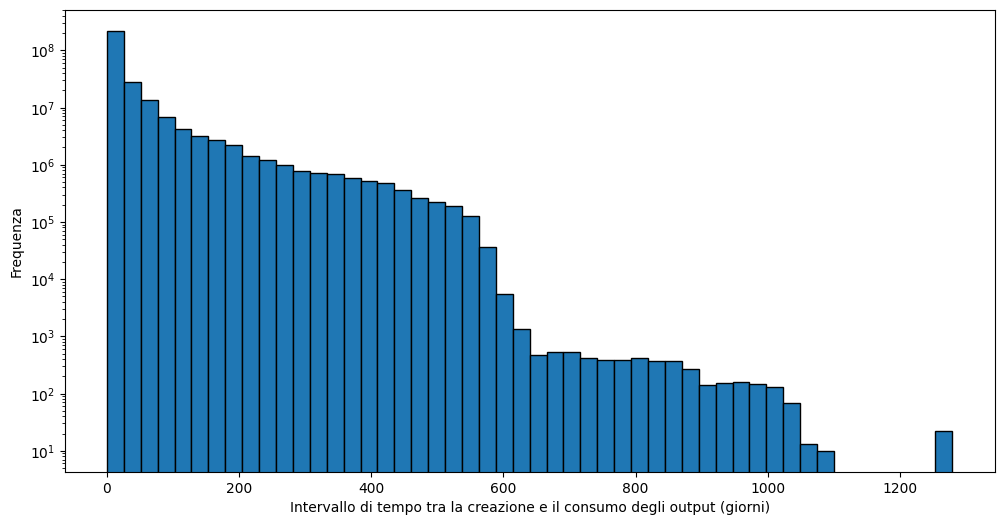

In [22]:
# Seleziona solo gli output che vengono consumati come input da un'altra transazione
output_consumati = Outputs[Outputs['txId'].isin(Inputs['prevTxId'])]

inputs_with_timestamps = pd.merge(Inputs[['txId','prevTxId']], Transactions[['txId','timestamp','fee']], left_on="txId", right_on="txId", how="left")
inputs_with_timestamps.rename(columns={"timestamp": "consumption_timestamp"}, inplace=True)

outputs_with_timestamps = pd.merge(output_consumati['txId'], Transactions[['txId','timestamp']], left_on="txId", right_on="txId", how="left")
outputs_with_timestamps.rename(columns={"timestamp": "creation_timestamp"}, inplace=True)
merged_data = pd.merge(inputs_with_timestamps, outputs_with_timestamps, left_on="prevTxId", right_on="txId", how="inner", suffixes=("_input", "_output"))
merged_data["time_interval"] = merged_data["consumption_timestamp"] - merged_data["creation_timestamp"]

# Calcola l'intervallo di tempo in ore direttamente durante la creazione dell'istogramma
time_interval_hours = (merged_data["time_interval"].dt.total_seconds() / (3600*24)).astype('float64')

# Disegna l'istogramma
plt.figure(figsize=(12, 6))
plt.hist(time_interval_hours, bins=50, edgecolor='black')
plt.xlabel("Intervallo di tempo tra la creazione e il consumo degli output (giorni)")
plt.ylabel("Frequenza")
plt.yscale('log')
plt.show()

Un'ulteriore analisi che potrebbe essere interessante è esaminare la correlazione tra le commissioni delle transazioni e il tempo necessario per confermare una transazione. Questo potrebbe aiutare a capire quanto le commissioni influenzano il tempo di conferma delle transazioni nel periodo considerato.

Purtroppo, non avendo il timestamp in cui la transazione sia stata inserita nella rete, ho calcolato il tempo che intercorre fra la transazione che genera l'output e e quella che lo spende.

Per farlo, ho iniziato unendo il DataFrame delle transazioni con quello degli input di transazione, in modo da avere le informazioni sulle commissioni e l'ID di transazione corrispondente nello stesso DataFrame.

Successivamente, ho unito il DataFrame delle transazioni con quello degli output di transazione. Ho anche rinominato le colonne per evitare conflitti durante l'unione successiva.

Opzionalmente effettuiamo un campionamento degli input nel caso il calcolo sia troppo lento.

Successivamente, i DataFrame transaction_inputs_sample e transaction_outputs_sample vengono ordinati in base a timestamp e timestamp_prev rispettivamente. Questo passaggio è necessario per l'operazione merge_asof. è simile a un'operazione di unione ordinata, ma ci permette di unire due DataFrame basati su colonne che non sono esattamente uguali, ma che hanno valori vicini.

Il tempo di conferma per ogni transazione viene calcolato sottraendo timestamp_prev da timestamp. Il risultato è il tempo trascorso in secondi tra la creazione dell'output e il suo consumo come input in un'altra transazione.

La correlazione tra commissioni e tempo per spendere l'UXTO è: 0.028944237140702288


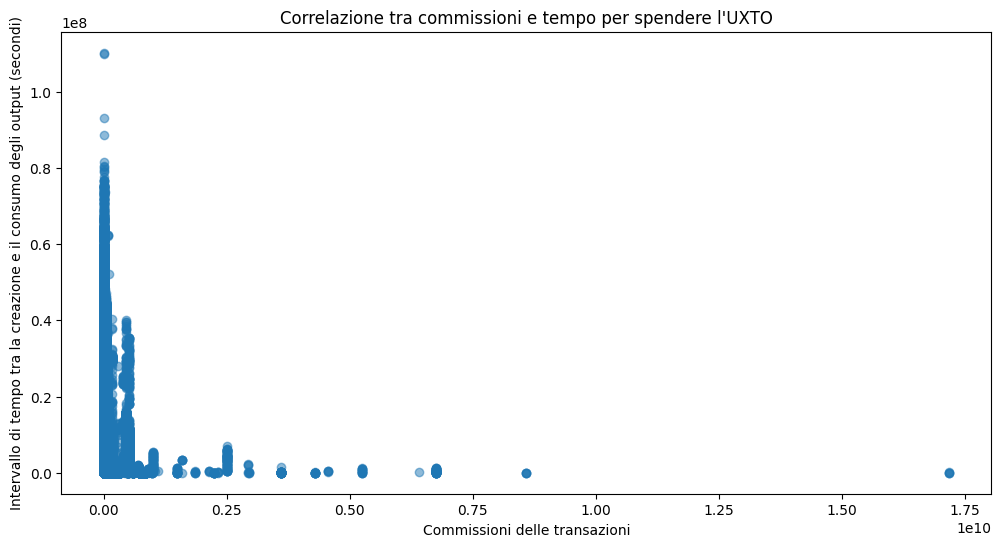

In [23]:
transaction_inputs = pd.merge(Transactions[['txId', 'timestamp', 'fee']], Inputs[[
                              'txId', 'prevTxId']], on='txId')

# Rinomina le colonne per evitare conflitti durante il merge_asof
transaction_outputs = pd.merge(Transactions[[
                               'txId', 'timestamp']], Outputs['txId'], left_on='txId', right_on='txId', suffixes=('', '_prev'))

transaction_outputs.rename(
    columns={'txId': 'prevTxId', 'timestamp': 'timestamp_prev'}, inplace=True)

transaction_inputs_sample = transaction_inputs#.sample(frac=0.2) nel caso sia troppo lento effettuiamo un sampling
transaction_outputs_sample = transaction_outputs[transaction_outputs['prevTxId'].isin(transaction_inputs_sample['txId'])].copy()
# Ordina i DataFrame in base ai prevTxId e ai timestamp
transaction_inputs_sample.sort_values(['timestamp'], inplace=True)
transaction_outputs_sample.sort_values(['timestamp_prev'], inplace=True)

# Esegui il merge_asof tra i DataFrame degli output e degli input
transaction_outputs_sample = pd.merge_asof(transaction_inputs_sample, transaction_outputs_sample[[
                                    'prevTxId', 'timestamp_prev']], left_on='timestamp', right_on='timestamp_prev', by='prevTxId', direction='backward')

# Calcola il tempo che intercorre fra la creazione dell'UXTO e il suo utilizzo
transaction_outputs_sample['time_interval'] = (
    transaction_outputs_sample['timestamp'] - transaction_outputs_sample['timestamp_prev']).dt.total_seconds()


transaction_outputs_sample_filtered = transaction_outputs_sample
# Calcola la correlazione tra le commissioni e il tempo
correlation = transaction_outputs_sample_filtered['fee'].corr(
    transaction_outputs_sample_filtered['time_interval'])

print("La correlazione tra commissioni e tempo per spendere l'UXTO è:", correlation)

# Visualizza i risultati in un grafico a dispersione
plt.figure(figsize=(12, 6))
plt.scatter(transaction_outputs_sample_filtered['fee'],
            transaction_outputs_sample_filtered['time_interval'], alpha=0.5)
plt.xlabel("Commissioni delle transazioni")
plt.ylabel("Intervallo di tempo tra la creazione e il consumo degli output (secondi)")
# plt.yscale('log')
# plt.xscale('log')
plt.title("Correlazione tra commissioni e tempo per spendere l'UXTO")
plt.show()

Stesso grafico ma consideriamo solo le transazioni con commissione che rientrano fra il primo e il terso quartile

La correlazione tra commissioni e tempo  per spendere l'UXTO è: -0.16920173212152284


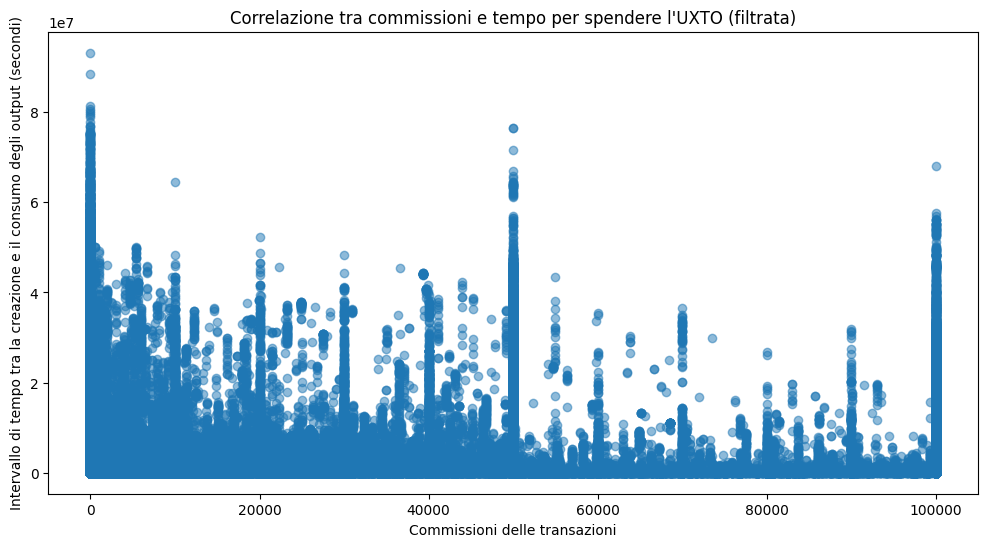

In [24]:
# Calcola il primo e il terzo quartile e l'intervallo interquartile (IQR)
Q1 = transaction_outputs_sample['fee'].quantile(0.25)
Q3 = transaction_outputs_sample['fee'].quantile(0.75)
IQR = Q3 - Q1

# Crea una maschera booleana per filtrare gli outlier
mask = ((transaction_outputs_sample['fee'] >= (Q1)) &
        (transaction_outputs_sample['fee'] <= (Q3)))

# Filtra il DataFrame utilizzando la maschera
transaction_outputs_sample_filtered = transaction_outputs_sample[mask]
# Calcola la correlazione tra le commissioni e il tempo di conferma
correlation = transaction_outputs_sample_filtered['fee'].corr(
    transaction_outputs_sample_filtered['time_interval'])

print("La correlazione tra commissioni e tempo  per spendere l'UXTO è:", correlation)

# Visualizza i risultati in un grafico a dispersione
plt.figure(figsize=(12, 6))
plt.scatter(transaction_outputs_sample_filtered['fee'],
            transaction_outputs_sample_filtered['time_interval'], alpha=0.5)
plt.xlabel("Commissioni delle transazioni")
plt.ylabel("Intervallo di tempo tra la creazione e il consumo degli output (secondi)")
plt.title("Correlazione tra commissioni e tempo per spendere l'UXTO (filtrata)")
plt.show()

## Clustering

Questa parte è stata sviluppata nei file preprocessing.py, che genera un file json, e scaper.py che partendo dal json effettua lo scraping su i due siti proposti.I notebook non gestiscono bene la memoria RAM, con i vari merge l'utilizzo totale raggiuge facilmente i 16GB e non viene liberata a fine processamento. Lascio anche qui il codice per comodità

In [25]:
from collections import defaultdict

Per prima cosa ho ridotto i DataFrame degli input e output alle colonne necessarie per il mio studio: 'addressId', 'txId' e 'position' per gli output, e 'txId', 'prevTxId', e 'prevTxpos' per gli input.

Successivamente, ho effettuato un'operazione di merge tra i DataFrame degli input e degli output, utilizzando le colonne 'prevTxId' e 'prevTxpos' per gli input e 'txId' e 'position' per gli output. Questo merge mi ha permesso di collegare ogni input con il relativo output precedente, formando così una mappa delle transazioni di Bitcoin.

Infine, ho filtrato solo le transazioni con più di un input. Questo è stato fatto utilizzando il metodo 'duplicated' di Pandas con il parametro 'subset' impostato su 'txId_x', che è l'ID della transazione degli input, e 'keep' impostato su 'False' per considerare tutti i duplicati. Il DataFrame risultante, 'multiple_input_txs', contiene quindi solo le transazioni che coinvolgono più di un input.

In [26]:
# Select only the necessary columns
reduced_outputs = Outputs[['addressId', 'txId', 'position']]
reduced_inputs = Inputs[['txId', 'prevTxId', 'prevTxpos']]

# Merge Inputs and Outputs using prevTxId
merged_data = pd.merge(reduced_inputs, reduced_outputs, left_on=['prevTxId', 'prevTxpos'], right_on=['txId', 'position'], how='inner')

# Filtra solo le transazioni con più di un input
multiple_input_txs = merged_data[merged_data.duplicated(subset=['txId_x'], keep=False)]


Per aggregare gli indirizzi in clusterho utilizzato l'algoritmo Union-Find, noto anche come Disjoint-Set, che è estremamente efficiente nel raggruppare elementi in insiemi disgiunti.

Ho implementato l'algoritmo Union-Find in Python tramite una classe denominata UnionFind. Questa classe ha due attributi principali: parent, che tiene traccia del "genitore" di ogni nodo, e rank, che tiene traccia della "profondità" di ogni albero nella foresta di alberi formata dalla struttura Union-Find.

La classe UnionFind ha tre metodi fondamentali: make_set, che inizializza un nuovo set con un solo elemento; find, che restituisce il rappresentante (o "radice") del set a cui appartiene un dato elemento; e union, che unisce due set in uno solo.

Per raggruppare gli indirizzi, ho definito una funzione cluster_addresses_union_find_opt_v4. Questa funzione inizia creando un'istanza di UnionFind e inizializzando ogni indirizzo Bitcoin unico come un set distinto con make_set.

Poi, per ogni gruppo di indirizzi che appare insieme come input in una stessa transazione (raggruppati per 'txId_x'), unisco tutti gli indirizzi in un unico set con il metodo union. Questo effettivamente crea un cluster per ogni gruppo di indirizzi che sono collegati tra loro tramite transazioni.

Infine, creo un dizionario cluster_mapping che mappa ogni radice di un set (ottenuta con il metodo find) alla lista degli indirizzi che appartengono a quel set. Questo dizionario rappresenta i clusters di indirizzi collegati che ho identificato nei dati delle transazioni Bitcoin.

### Ottimizzazioni usate nell'algoritmo Union-Find

#### Union by Rank

L'ottimizzazione "Union by Rank" è usata nel processo di unione di due insiemi. Quando due insiemi vengono uniti, uno dei due diventa il genitore dell'altro. Senza questa ottimizzazione, potrebbe accadere che un insieme grande venga fatto diventare figlio di un insieme piccolo, il che avrebbe come conseguenza un albero molto profondo e quindi operazioni di "find" molto costose.

Per risolvere questo problema, manteniamo un "rank" per ogni insieme, che è una stima della sua altezza. Quando due insiemi di diverso rango vengono uniti, l'insieme con rango minore diventa figlio di quello con rango maggiore. Questo garantisce che l'altezza dell'albero non aumenti. Se due insiemi hanno lo stesso rango, uno di essi diventa figlio dell'altro e il rango del genitore aumenta di 1. Questo aiuta a mantenere gli alberi bilanciati, garantendo che le operazioni di "find" siano più efficienti.

#### Path Compression

La compressione del percorso è un'ottimizzazione utilizzata nella funzione "find". Senza questa ottimizzazione, la funzione "find" segue il percorso dall'elemento richiesto fino al genitore dell'insieme, che può essere costoso se l'albero è profondo.

La compressione del percorso risolve questo problema facendo in modo che ogni elemento nel percorso punti direttamente al genitore dell'insieme. In pratica, ciò significa che durante l'esecuzione della funzione "find", modifichiamo il genitore di ogni elemento che incontriamo per farlo puntare direttamente alla radice dell'insieme. Questo significa che le future operazioni "find" su quegli elementi (o sugli elementi lungo il percorso) saranno molto più veloci.

In [27]:
class UnionFind:
    def __init__(self):
        self.parent = dict()
        self.rank = dict()

    def make_set(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x == root_y:
            return

        if self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_x] = root_y
            if self.rank[root_x] == self.rank[root_y]:
                self.rank[root_y] += 1
                
def cluster_addresses_union_find_opt_v4(multiple_input_txs):
    uf = UnionFind()

    # Crea un set di tutti gli indirizzi presenti nei dati
    all_addresses = set(multiple_input_txs['addressId'].unique())

    # Inizializza l'oggetto uf con tutti gli indirizzi unici
    for address in all_addresses:
        uf.make_set(address)

    for _, group in multiple_input_txs.groupby('txId_x'):
        addresses = group['addressId'].tolist()

        # Unisci tutti gli indirizzi nell'input corrente nel nuovo cluster
        for i in range(1, len(addresses)):
            uf.union(addresses[i - 1], addresses[i])

    cluster_mapping = {}
    for address in all_addresses:
        root = uf.find(address)
        if root not in cluster_mapping:
            cluster_mapping[root] = []
        cluster_mapping[root].append(address)
        
    return cluster_mapping


In [28]:
output_clustering = cluster_addresses_union_find_opt_v4(multiple_input_txs)
output_clustering

{8313261: [8388609,
  8388712,
  8388713,
  8388719,
  8388738,
  8388878,
  8389008,
  8389529,
  8389565,
  8389926,
  8390025,
  8390033,
  8390516,
  8390523,
  8390894,
  8391209,
  8391531,
  8391598,
  8391603,
  8391940,
  8392227,
  8392338,
  8392757,
  8392769,
  8394210,
  8394598,
  8394765,
  8395041,
  8397001,
  8397029,
  8397205,
  8397452,
  8397458,
  8397481,
  8397554,
  8397687,
  8397692,
  8397702,
  8397714,
  8397718,
  8397721,
  8397723,
  8397745,
  8397752,
  8397763,
  8397829,
  8398241,
  8398293,
  8398296,
  8398301,
  8398312,
  8398320,
  8398324,
  8398327,
  8398524,
  8398527,
  8398529,
  8398533,
  8398584,
  8398585,
  8398592,
  8398600,
  8398604,
  8398619,
  8398624,
  8398627,
  8398631,
  8398686,
  8398692,
  8398733,
  8398736,
  8398745,
  8398747,
  8398751,
  8398798,
  8398842,
  8398854,
  8398857,
  8398865,
  8398889,
  8398933,
  8398937,
  8398944,
  8398947,
  8398952,
  8398956,
  8398963,
  8398973,
  8398985,
  8399001,
 

Uso il modulo `json` per salvare e caricare il dizionario dei cluster, così da poterlo riutilizzare anche dopo aver chiuso il notebook

In [29]:
import json
    
    
with open("clusters2.json", "w") as outfile:
    json.dump({int(k):[int(i) for i in v] for k,v in output_clustering.items()}, outfile)

In [31]:
import json

with open("clusters2.json","r") as f:
    data = json.load(f)

Utilizzo le funzioni messe a disposizione da Numpy per calcolare la media, la minima e la massima dimensione dei cluster.

In [ ]:
import numpy as np

# Calcola le dimensioni di ciascun cluster
cluster_sizes = [len(addresses) for addresses in data.values()]

# Calcola la dimensione media, minima e massima dei cluster
mean_size = np.mean(cluster_sizes)
min_size = np.min(cluster_sizes)
max_size = np.max(cluster_sizes)

print("Dimensione media dei cluster:", mean_size)
print("Dimensione minima dei cluster:", min_size)
print("Dimensione massima dei cluster:", max_size)

Dimensione media dei cluster: 8.404291154348938
Dimensione minima dei cluster: 1
Dimensione massima dei cluster: 259773


Mostro con un istogramma la distribuzione delle dimensioni dei cluster, su scala logaritmica.

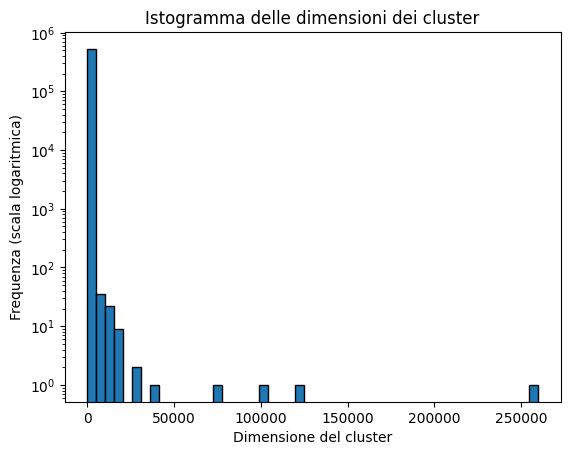

In [ ]:

plt.hist(cluster_sizes, bins=50, edgecolor='black', log=True)
plt.xlabel('Dimensione del cluster')
plt.ylabel('Frequenza (scala logaritmica)')
plt.title('Istogramma delle dimensioni dei cluster')
plt.show()

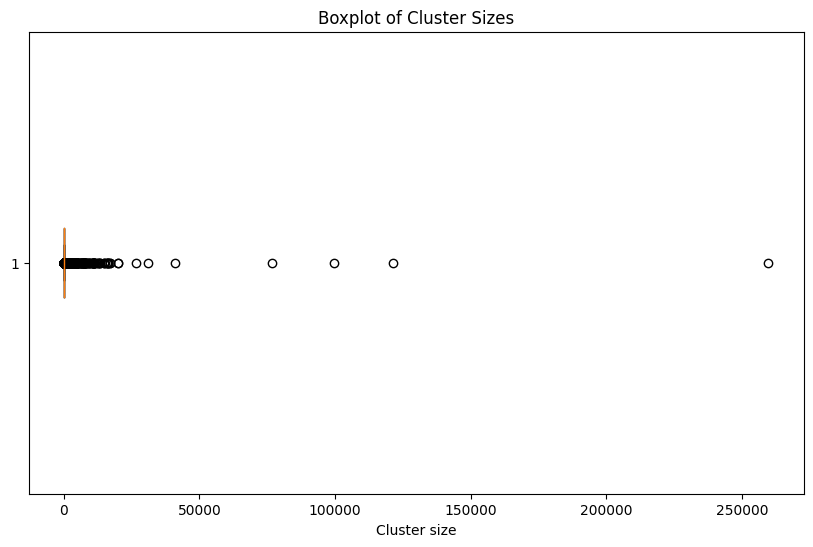

In [ ]:
cluster_sizes_series = pd.Series(cluster_sizes)

plt.figure(figsize=(10, 6))
plt.boxplot(cluster_sizes_series, vert=False)
plt.title('Boxplot of Cluster Sizes')
plt.xlabel('Cluster size')
plt.show()

Un altro istogramma, stavolta focalizzato sulla distribuzione della dimensione dei cluster che hanno meno di 100 indirizzi

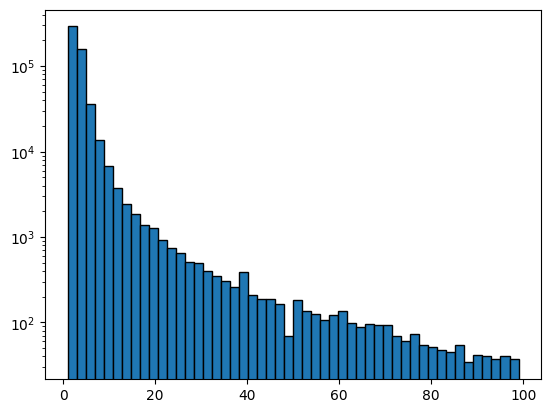

In [ ]:
truncated_cluster_sizes = cluster_sizes_series[cluster_sizes_series < 100]   
plt.hist(truncated_cluster_sizes,edgecolor='black', bins=50)
plt.yscale('log')
plt.show()

Creo una distribuzione cumulativa (CDF, Cumulative Distribution Function) delle dimensioni dei cluster. Questo tipo di distribuzione mostra la probabilità che una variabile casuale X sia minore o uguale a un certo valore x.

Il parametro `density=True` normalizza i dati in modo che l'integrale (o l'area totale sotto la curva) sia uguale a 1.

Moltiplico il conteggio in ogni bin per la larghezza del bin, per ottenere la probabilità per ciascun bin così che la somma di tutti i bin sia uguale a uno.

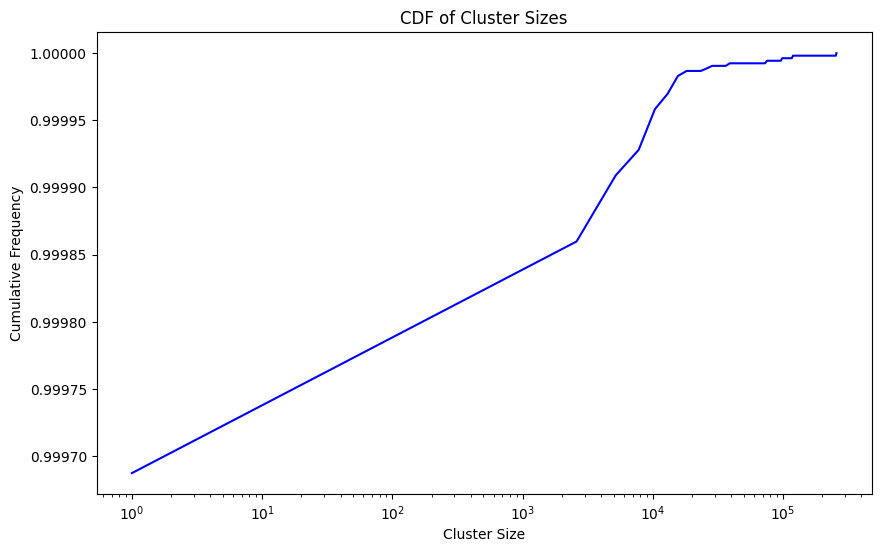

In [ ]:
# Genera i dati per la CDF
values, base = np.histogram(cluster_sizes, bins=100, density=True)
bin_widths = base[1:] - base[:-1]
values *= bin_widths
cumulative = np.cumsum(values)
# Crea un nuovo grafico
plt.figure(figsize=(10, 6))

# Traccia i dati
plt.plot(base[:-1], cumulative, c='blue')
plt.xscale('log')
# Imposta i titoli del grafico e degli assi
plt.title('CDF of Cluster Sizes')
plt.xlabel('Cluster Size')
plt.ylabel('Cumulative Frequency')

# Mostra il grafico
plt.show()

In [ ]:
sorted_cluster = sorted(data.items(), key =lambda x: len(x[1]),reverse=True)

top_10 = sorted_cluster[0:10]

del sorted_cluster


In [ ]:
cluster0 = pd.DataFrame(top_10[0][1] + [top_10[0][0]],columns=['addressId'])
cluster0[cluster0['addressId'] == top_10[0][0]]

,addressId
259773,981854


In [ ]:
cluster10 = pd.DataFrame(top_10[9][1] + [top_10[9][0]],columns=['addressId'])
cluster10[cluster10['addressId'] == top_10[9][0]]

,addressId
16977,4193037


In [ ]:
x =Mapping.merge(cluster10,how='inner')

In [ ]:
x

,hash,addressId
0,1AGet7b6HQrdnV5Lfbqc4tysYbxxFL2E21,4190509
1,1PEgTXU5kef2z7ipcEe8H4h85J6V4zQh7C,4191757
2,1MkY2w9VysSybfMJnutEXRhapLeXpBgMFa,4192204
3,1DdkkzuBAegoTcWnqQiD8qcJSBEiWW3rZQ,4192427
4,1B1bZBAYobSyXhAYvAB69EZXANaFJgqTPe,4192442
...,...,...
16972,18tgDCjy4nVsegGuJYjAbBGTnZruDYpEFp,4463134
16973,1uLbnmwWCwG28ARDZXV5JsZ3im1bup4Jg,4463135
16974,1XFio9STHNmSnAb3QfU26BzSCi48qPb6D,4463189
16975,12uwmm6BtjhhFDEa8dwtX1ZU9WvWiJHuBo,4463340


Per sviluppare il bot ho preferito utilizzare la libreria python-statemachine per facilitarmi la scrittura della logica tramite l'utilizzo di una macchina a stati finiti

La classe principale è CrawlerBot, che eredita da StateMachine, una classe per creare macchine a stati finiti. Una macchina a stati finiti è un modello computazionale che può essere in uno tra un numero finito di stati in un dato momento. 

`CrawlerBot` ha diversi stati, tra cui `start`, `address_page_loaded`, `wallet_page_loaded`, `banned`, e `OK`. Ciascuno di questi rappresenta una fase del processo di scraping. Ad esempio, `address_page_loaded` rappresenta lo stato in cui la pagina web con le informazioni dell'indirizzo è stata caricata.

La classe `CrawlerBot` ha anche diverse transizioni, che rappresentano i cambiamenti di stato. Ad esempio, `loading_for_address` rappresenta la transizione dallo stato `start` allo stato `address_page_loaded`, che si verifica quando ci sono indirizzi disponibili da analizzare. Allo stesso modo, `loading_for_wallet` rappresenta la transizione dallo stato `address_page_loaded` allo stato `wallet_page_loaded`, a meno che non sia presente un CAPTCHA.

Il ciclo principale alla fine del codice inizializza un oggetto CrawlerBot per ciascuno dei 10 cluster principali di indirizzi Bitcoin, esegue lo scraping delle informazioni relative a ciascuno di questi indirizzi, e infine registra queste informazioni in un DataFrame di pandas. I risultati vengono quindi salvati in un file CSV per l'analisi successiva.

In [ ]:
from selenium.webdriver.remote.webelement import WebElement
from statemachine import StateMachine, State
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

class CrawlerBot(StateMachine):
    # Definisci gli stati
    start = State('Start', initial=True)
    address_page_loaded = State('Address page loaded')
    wallet_page_loaded = State('Wallet page loaded')
    banned = State('Banned',final=True)
    OK = State("OK",final=True)

    # Definisci le transizioni
    loading_for_address = start.to(address_page_loaded,cond='thereAreAddress') | address_page_loaded.to(address_page_loaded,cond='thereAreAddress') | wallet_page_loaded.to(address_page_loaded,cond='thereAreAddress')
    loading_for_wallet = address_page_loaded.to(wallet_page_loaded,unless='thereIsCaptcha') | address_page_loaded.to(address_page_loaded,cond='thereAreAddress') | address_page_loaded.to(OK,unless='thereAreAddress')
    to_banned = address_page_loaded.to(banned,cond='thereIsCaptcha')

    finish = address_page_loaded.to(OK)

    def __init__(self, addresses,oneshot):
        self.driver = webdriver.Edge()  # o qualsiasi altro browser preferisci        
        self.driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": """
            Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
            })
        """
        })   
        self.oneshot = oneshot
        self.driver.implicitly_wait(3)
        self.addresses = set(addresses)  # Utilizzo un set per facilitare la rimozione degli indirizzi
        self.current_address = None
        self.wallet_names = {}
        super(CrawlerBot, self).__init__()

    def thereAreAddress(self):
        return len(self.addresses) > 0
        
    def thereIsCaptcha(self):
        try:
            captcha = self.driver.find_element(By.XPATH,"//*[contains(@class, 'captcha')]")
            print("Elemento con classe 'captcha' trovato.")
            return True
        except NoSuchElementException:
            print("Elemento con classe 'captcha' non trovato.")
            return False

    def get_address_url(self):
        return f"https://bitinfocharts.com/bitcoin/address/{self.current_address}" 

    def on_enter_address_page_loaded(self):
        self.current_address = self.addresses.pop()
        self.driver.get(self.get_address_url()) 
        self._scrape_wallet_name()        

    def on_enter_wallet_page_loaded(self):
        self._check_wallet_addresses()
        self.loading_for_address()

    def on_enter_OK(self):
        self.driver.quit()

    def _scrape_wallet_name(self):
        try:
            wallet_link = self.driver.find_element(By.XPATH,'//a[contains(@href, "/wallet/")]')
            self.wallet_names[self.current_address] = wallet_link.get_attribute("href").split('/wallet/')[-1]
            if (self.oneshot):
                self.finish()
                return
            wallet_link.click()
            print("Elemento link wallet trovato.")
            self.loading_for_wallet()
            return
        except NoSuchElementException:
            print("Elemento link wallet non trovato.")

        try:
            captcha = self.driver.find_element(By.XPATH,"//*[contains(@class, 'captcha')]")
            print("Elemento con classe 'captcha' trovato.")
            self.to_banned()
            return
        except NoSuchElementException:
            print("Elemento con classe 'captcha' non trovato.")
        self.loading_for_address()
        

    def _check_wallet_addresses(self):
        try:
            address_elements = self.driver.find_elements(By.CSS_SELECTOR,
                "#ShowAddresesContainer a"
            )
            wallet_addresses = {el.text for el in address_elements}
            self.addresses -= wallet_addresses  # Remove the addresses present in the wallet
            return
        except NoSuchElementException:
            print("Elemento ShowAddresesContainer non trovato.")

        try:
            captcha = self.driver.find_element(By.XPATH,"//*[contains(@class, 'captcha')]")
            print("Elemento con classe 'captcha' trovato.")
        except NoSuchElementException:
            print("Elemento con classe 'captcha' non trovato.")
        self.loading_for_address()

    def run(self):
        self.loading_for_address()


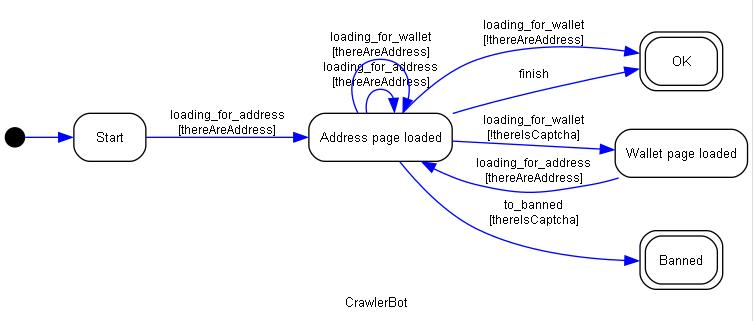

In [ ]:
from statemachine.contrib.diagram import DotGraphMachine
graph = DotGraphMachine(CrawlerBot)
dot = graph()
dot.write_jpeg('./crawlerFSM.jpeg') # è necessario Graphviz

In [ ]:
addresses = x['hash'][1:10]  # Sostituisci con i tuoi indirizzi
bot = CrawlerBot(addresses,True)
bot.run()

In [ ]:
print(bot.wallet_names)
prova=pd.DataFrame(bot.wallet_names.items(),columns=['Address','Wallet'])
prova

{'1J66p6w5P35g1ySCCTKbDx5iceQjAbHpFq': '330612'}


,Address,Wallet
0,1J66p6w5P35g1ySCCTKbDx5iceQjAbHpFq,330612


La funzione accetta un parametro indirizzo, che dovrebbe essere un indirizzo Bitcoin.

Costruisce un URL concatenando https://www.walletexplorer.com/address/ con l'indirizzo fornito.

Effettua una richiesta GET a questo URL utilizzando la libreria requests.

Aspetta 4 secondi per evitare di essere bloccati per eccesso di richieste.

Controlla se la richiesta è andata a buon fine verificando se lo status code della risposta è 200.

Se la richiesta ha avuto successo, utilizza la libreria BeautifulSoup per analizzare il contenuto HTML della risposta.

Cerca un elemento div con classe 'walletnote' nel documento HTML.

Se trova tale elemento, scorre i suoi figli alla ricerca di un elemento 'a'.

Se trova un elemento 'a', estrae il suo attributo 'href'.

Il valore di 'href' sembra essere un URL che include /wallet/, quindi la funzione estrae la parte dell'URL che segue /wallet/.

Se non riesce a trovare le informazioni o se la richiesta GET fallisce, la funzione ritorna un messaggio di errore appropriato.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

# Lista di indirizzi Bitcoin
indirizzi_bitcoin = x['hash'][1:2]
# [
#     '1BX4f93ZeMuZkozrTksDNFDzB62uUGxNp3',
#     '1D8Zb5SLxoR89PEiy9ewRyQ19gPZfoC8Xj',
# ]

# Funzione per cercare un indirizzo Bitcoin su WalletExplorer
def cerca_indirizzo(indirizzo):
    url = f'https://www.walletexplorer.com/address/{indirizzo}'
    response = requests.get(url)
    time.sleep(4)
    # Verifica se la richiesta è andata a buon fine
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Estrai le informazioni di interesse, ad esempio il saldo dell'indirizzo
        div_walletnote  = soup.find('div', {'class': 'walletnote'})

        # Cerca l'elemento 'a' figlio del div trovato
        elemento_a = None
        if div_walletnote:
            for child in div_walletnote.children: # type: ignore
                if child.name == 'a': # type: ignore
                    elemento_a = child
                    break

        # Estrai l'attributo 'href' dell'elemento 'a' trovato
        href = elemento_a['href'] if elemento_a else None # type: ignore
        if href:
            return href.split('/wallet/')[-1]
        else:
            return 'Informazioni non trovate'
    else:
        return f'Errore nella richiesta: {response.status_code}'

# Cerca gli indirizzi nella lista
for indirizzo in indirizzi_bitcoin:
    wallet = cerca_indirizzo(indirizzo)
    print(f'Indirizzo: {indirizzo} - Wallet: {wallet}')

Indirizzo: 1PEgTXU5kef2z7ipcEe8H4h85J6V4zQh7C - Wallet: /wallet/00002c4379b1827f


In [ ]:
risultati = pd.read_csv('DataSets/risultato.csv')
risultati.groupby(['ChiaveCluster','Wallet'])['Wallet'].count()

ChiaveCluster  Wallet             
0.0            CoinJoinMess           1
               F2Pool                 1
1.0            SilkRoadMarketplace    2
2.0            00005795a77580a4       1
               65086                  1
3.0            Instawallet.org        2
4.0            00003ee5f7d2cd2a       1
               159828                 1
5.0            BTC-e.com-old          1
               Eligius                1
6.0            74324                  1
               BtcDice.com            1
7.0            00010687d110bb04       1
               129616                 1
8.0            0000228a5583c280       1
               238527                 1
9.0            00002c4379b1827f       1
               330637                 1
Name: Wallet, dtype: int64

Bitinfocharts.com e WalletExplorer.com sono due servizi diversi che forniscono informazioni sugli indirizzi Bitcoin e sulle transazioni associate. Tuttavia, la loro metodologia per associare un indirizzo Bitcoin a un portafoglio può differire, portando a risultati diversi.

Questi servizi potrebbero utilizzare algoritmi diversi per raggruppare gli indirizzi Bitcoin in portafogli. Ad esempio, un servizio potrebbe utilizzare un'euristica di "comproprietà" (se due indirizzi sono input nella stessa transazione, appartengono presumibilmente allo stesso proprietario) mentre un altro potrebbe utilizzare un'euristica di "cambio" (se un indirizzo è usato come output di cambio in una transazione, appartiene presumibilmente allo stesso proprietario del input). 

La blockchain di Bitcoin è continuamente aggiornata con nuove transazioni. Se i servizi non si aggiornano allo stesso ritmo, potrebbero non avere gli stessi dati al momento dell'interrogazione.

È importante notare che la proprietà di un indirizzo Bitcoin è intrinsecamente privata e, a meno che l'utente non scelga di rendere pubblica questa informazione, qualsiasi tentativo di associare un indirizzo a un portafoglio o a un utente sarà sempre una speculazione.